In [3]:
from sklearn import *
import lightgbm as lgbm
import xgboost as xgb
import catboost as cat
from sklearn.model_selection import train_test_split
from sqlalchemy import column
import pandas as pd
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [4]:
def convert_to_category(X):
    for col in X.columns:
        if ( (X[col].dtype != 'int64') and (X[col].dtype != 'float64') and (X[col].dtype != 'bool')):
            X[col] = X[col].astype('category')
            
    return X

In [5]:
stores_train = pd.read_csv('data/stores_train_with_extra_features.csv')
stores_test = pd.read_csv('data/stores_test_with_extra_features.csv')

plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets_ages = pd.read_csv('data/grunnkrets_age_distribution.csv')
grunnkrets_household_types = pd.read_csv('data/grunnkrets_households_num_persons.csv')
grunnkrets_household_income = pd.read_csv('data/grunnkrets_income_households.csv')


stores_train_copy= stores_train.copy()

plaace_hierarchy_copy = plaace_hierarchy.copy()
plaace_hierarchy_copy.drop(columns='sales_channel_name', inplace=True)
plaace_hierarchy_copy['lv1'] = plaace_hierarchy_copy['lv1'].astype('category')
plaace_hierarchy_copy['lv2'] = plaace_hierarchy_copy['lv2'].astype('category')


grunnkrets_copy = grunnkrets.copy()
grunnkrets_copy.rename(columns={'year': 'year_1'}, inplace=True)

grunnkrets_ages_copy = grunnkrets_ages.copy()
grunnkrets_ages_copy.rename(columns={'year': 'year_2'}, inplace=True)
grunnkrets_ages_copy['grunnkrets_population'] = grunnkrets_ages_copy.iloc[:, 2:].sum(axis=1)

grunnkrets_household_types_copy = grunnkrets_household_types.copy()
grunnkrets_household_types_copy.rename(columns={'year': 'year_3'}, inplace=True)
grunnkrets_household_types_copy[grunnkrets_household_types_copy.columns[2:]] = grunnkrets_household_types_copy[grunnkrets_household_types_copy.columns[2:]].astype('int64')

grunnkrets_household_income_copy = grunnkrets_household_income.copy()
grunnkrets_household_income_copy.rename(columns={'year': 'year_4', 'singles': 'singles_income','couple_without_children':'couple_without_children_income'}, inplace=True)
grunnkrets_household_income_copy.rename(columns={'singles': 'singles_income', }, inplace=True)

    

df = stores_train_copy

df = pd.merge(df, plaace_hierarchy_copy, on='plaace_hierarchy_id', how='left')
df = pd.merge(df, grunnkrets_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_ages_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_types_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_income_copy, on='grunnkrets_id', how='left')



df['grunnkrets_population_density'] = df['grunnkrets_population'] / df['area_km2']



df.drop_duplicates(subset=['store_id'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)



columns_to_drop = [#'revenue',
                  'store_id',
                  'plaace_hierarchy_id',
                  'grunnkrets_id',
                  'year',
                  'address',
                  'store_name',
                  
                  'year_1',
                  'geometry',
                  
                  #'area_km2',
               
                  'grunnkrets_name',
                  
                  'district_name',
                  'municipality_name',
                  
                  
                  'year_2',
                  'year_3',
                  'year_4',
                 
                
                  'sales_channel_name',
                   #'mall_name',
                  #'chain_name',
                  
                  
                  
                     'lv1',
                  'lv2',
                  'lv3',
                  'lv4',
                  
                  # 'lv1_desc',
                  # 'lv2_desc',
                  # 'lv3_desc',
                  # 'lv4_desc'
                
#                 'closest_busstop',
                  
#     'num_closest_busstops_250m',
#    'num_closest_busstops_500m',

#        'num_closest_busstops_1000m', 'num_closest_busstops_2500m',
#        'num_closest_busstops_5000m', 
#        'num_closest_busstops',
#        'num_closest_busstops_10000m', 
#      'num_closest_busstops_12500m',
# 'num_closest_busstops_15000m',
# 'num_closest_busstops_20000m',
       
#        'closest_store_lv1', 'closest_store_lv2',
#        'closest_store_lv3', 'closest_store_lv4', 
       
#        'num_closest_stores_lv1_250m',   
#    'num_closest_stores_lv1_500m', 
   
#    'num_closest_stores_lv1_1000m',
    
#     'num_closest_stores_lv1_2500m',
#        'num_closest_stores_lv1_5000m', 
#        'num_closest_stores_lv1',
#        'num_closest_stores_lv1_10000m', 
# 'num_closest_stores_lv1_15000m',
       
#        'num_closest_stores_lv2_250m', 
   
   
#    'num_closest_stores_lv2_500m',
   
#     'num_closest_stores_lv2_1000m', 
    
#     'num_closest_stores_lv2_2500m',
#        'num_closest_stores_lv2_5000m',
#        'num_closest_stores_lv2',
#        'num_closest_stores_lv2_10000m', 'num_closest_stores_lv2_15000m',
       
#         'num_closest_stores_lv3_250m', 
   
   
#    'num_closest_stores_lv3_500m',
   
#        'num_closest_stores_lv3_1000m', 'num_closest_stores_lv3_2500m',
#        'num_closest_stores_lv3_5000m', 
#        'num_closest_stores_lv3',
#        'num_closest_stores_lv3_10000m', 'num_closest_stores_lv3_15000m',
       
#         'num_closest_stores_lv4_250m', 
   
#    'num_closest_stores_lv4_500m',
   
#        'num_closest_stores_lv4_1000m', 'num_closest_stores_lv4_2500m',
#        'num_closest_stores_lv4_5000m', 
#        'num_closest_stores_lv4',
#        'num_closest_stores_lv4_10000m', 'num_closest_stores_lv4_15000m',
#                   'distance_to_oslo',
                  # 'distance_to_bergen',
                  # 'distance_to_trondheim',
                  # 'distance_to_stavanger',
                  # 'distance_to_drammen',
                  # 'grunnkrets_population',
                  # 'grunnkrets_population_density',
                  
                  # 'num_closest_busstops_100m',
                  # 'num_closest_busstops_750m',
                  # 'num_closest_stores_lv1_100m',
                  # 'num_closest_stores_lv1_750m', 
                  # 'num_closest_stores_lv2_100m',
                  # 'num_closest_stores_lv2_750m',
                  # 'num_closest_stores_lv3_100m',
                  # 'num_closest_stores_lv3_750m',
              
                  # 'num_closest_stores_lv4_750m',
                  
                  ]


# fill in missing values of float columns with mean


X = df.drop(columns=columns_to_drop)
X = convert_to_category(X)

X['revenue'] = np.log1p(X['revenue'])


y = df.revenue
y = np.log1p(y)



categorical_features = X.select_dtypes(include=['category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# numerical_columns = numerical_columns.drop('revenue')

# X[numerical_columns] = np.log(X[numerical_columns])


# from sklearn.preprocessing import StandardScaler
# scaler =  StandardScaler()

# X[numerical_columns] = scaler.fit_transform(X[numerical_columns])




In [6]:
X['revenue']

0        2.944334
1        3.211972
2        2.839020
3        2.331755
4        1.709826
           ...   
12854    0.084341
12855    1.035317
12856    3.669314
12857    1.535145
12858    1.202372
Name: revenue, Length: 12859, dtype: float64

In [7]:
stores_train.shape

(12859, 73)

In [378]:
#colums_to_drop = columns_to_drop[1:]
stores_test_copy = stores_test.copy()

df = stores_test_copy
#df['revenue'] = 0

df = pd.merge(df, plaace_hierarchy_copy, on='plaace_hierarchy_id', how='left')
df = pd.merge(df, grunnkrets_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_ages_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_types_copy, on='grunnkrets_id', how='left')
df = pd.merge(df, grunnkrets_household_income_copy, on='grunnkrets_id', how='left')

df.drop_duplicates(subset=['store_id'], keep='first', inplace=True)
df['grunnkrets_population_density'] = df['grunnkrets_population'] / df['area_km2']

X_test = df.drop(columns = columns_to_drop)
X_test = convert_to_category(X_test)

numerical_columns = X_test.select_dtypes(include=['int64', 'float64']).columns



In [394]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,18 hours 54 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_levit_827rx6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.776 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [395]:
train = h2o.H2OFrame(X)

x = train.columns
y = "revenue"
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [396]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_models=100, seed=1, sort_metric='RMSE')
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |█
23:34:27.257: AutoML: XGBoost is not available; skipping it.

██████████████████████████████████████████████████████████████

In [385]:
test = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [386]:
preds = aml.leader.predict(test)
preds = np.expm1(preds.as_data_frame())

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


c:\Users\levit\.pyenv\pyenv-win\versions\3.10.7\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'chain_name' has levels not trained on: ["24 7 TRENINGSSENTER", "ACE SHOPS", "AVANCIA SPORT", "BADEMILJÃ˜", "BADERINGEN", "BAROKK FRISÃ˜R", "BERTONI NORWAY", "BIRK SPORT", "BLUE ENERGY", "DESINESS", ...23 not listed..., "SALT OG PEPPER HÃ˜NEFOSS", "SKOGSTAD DETALJ", "SKY FITNESS", "TIGER OF SWEDEN", "TIPPY", "VARMEFAG INVEST", "VITA EXCLUSIVE", "YOGIS", "ZAVANNA", "ZAXIZ FRISÃ˜R"]
  warnings.warn(w)
c:\Users\levit\.pyenv\pyenv-win\versions\3.10.7\lib\site-packages\h2o\job.py:83: UserWarning: Test/Validation dataset column 'mall_name' has levels not trained on: ["Aamodt Senter", "Bardufoss Torgsenter", "Bellevuesenteret", "BorgeÃ¥sen Senter", "CC Mart'n", "Combisenteret FiskÃ¥", "Coop Mega HÃ¸nefoss", "Coop Mega Ã˜vre Ã…rdal", "Cuben KjÃ¸pesenter", "De Syv SÃ¸stre kjÃ¸pesenter", ...37 not listed..., "StrÃ¸get", "Sundt Motehus", "Svelvik NÃ¦rsenter", "Tebo Senter",

In [387]:
preds

,predict
0,3.492914
1,4.599232
2,2.220939
3,5.251661
4,17.193011
...,...
8572,5.788027
8573,3.905905
8574,7.086504
8575,2.778951


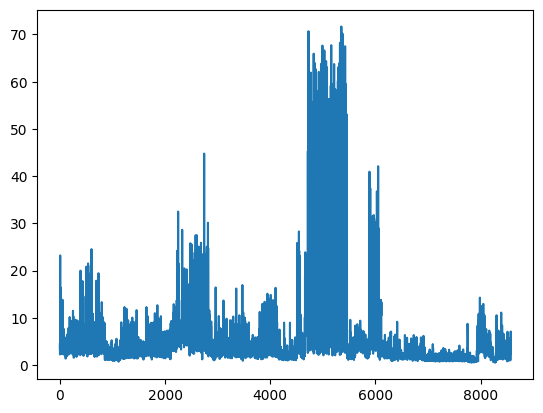

In [388]:
import matplotlib.pyplot as plt

plt.plot(preds)

In [389]:
preds

,predict
0,3.492914
1,4.599232
2,2.220939
3,5.251661
4,17.193011
...,...
8572,5.788027
8573,3.905905
8574,7.086504
8575,2.778951


In [390]:
submission = pd.DataFrame()
submission['id'] = stores_test['store_id']
submission['predicted'] = np.asarray(preds)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submissions/sample_submission.csv', index=False)
submission

,id,predicted
0,914206820-914239427-717245,3.492914
1,916789157-916823770-824309,4.599232
2,913341082-977479363-2948,2.220939
3,889682582-889697172-28720,5.251661
4,997991699-998006945-417222,17.193011
...,...,...
8572,917323003-917383529-844309,5.788027
8573,917353379-917411824-845904,3.905905
8574,917072302-917089248-833647,7.086504
8575,916960557-916993161-829908,2.778951
